# One step 단일 변수 시계열 예측
진행 과정:
- feed-forward 신경망 예측 모델을 훈련하기위한 시계열 데이터 준비
- Keras API를 위해 필요한 형태로 데이터를 가져온다
- keras의 기본 feed-forward NN을 수행하여 시계열에서 다음 시간 스텝 (시간 *t+1*)을 예측 
- 모델의 과적합을 줄이기 위해 early stopping 가능
- 테스트 데이터 세트을 이용하여 모델 평가

- GEFCom2014 예측 대회에서 사용된 데이터

- 2012년과 2014년 사이의 3 년간의 시간별 전기 부하 및 온도 값으로 구성

- 참고문헌 : Tao Hong, Pierre Pinson, Shu Fan, Hamidreza Zareipour, Alberto Troccoli and Rob J. Hyndman, "Probabilistic energy forecasting: Global Energy Forecasting Competition 2014 and beyond", International Journal of Forecasting, vol.32, no.3, pp 896-913, July-September, 2016

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 모든 칼럼의 실수를 소수점 2자리까지 표현하도록 정규식 설정
pd.options.display.float_format = '{:,.2f}'.format

energy = pd.read_csv('../data/energy.csv')
print(energy.shape) # 하루당 24개, 1달 약 720개, 1년 8760개, 3년 26304개
energy.head()

(26304, 3)


,timestamp,load,temp
0,2012-01-01 00:00:00,"2,698.00",32.00
1,2012-01-01 01:00:00,"2,558.00",32.67
2,2012-01-01 02:00:00,"2,444.00",30.00
3,2012-01-01 03:00:00,"2,402.00",31.00
4,2012-01-01 04:00:00,"2,403.00",32.00


In [12]:
# temp 컬럼 삭제
del energy["temp"]
energy.head()

,timestamp,load
0,2012-01-01 00:00:00,"2,698.00"
1,2012-01-01 01:00:00,"2,558.00"
2,2012-01-01 02:00:00,"2,444.00"
3,2012-01-01 03:00:00,"2,402.00"
4,2012-01-01 04:00:00,"2,403.00"


In [13]:
"""시간 순서대로 적용하기 위해(시퀀스적용) 문자열을 datetime 형으로 변경 후 인덱스로"""
energy["timestamp"] = pd.to_datetime(energy["timestamp"])

# inplace=True : 변경된 내용을 적용
energy.set_index('timestamp', inplace=True)
energy.head()

,load
timestamp,
2012-01-01 00:00:00,"2,698.00"
2012-01-01 01:00:00,"2,558.00"
2012-01-01 02:00:00,"2,444.00"
2012-01-01 03:00:00,"2,402.00"
2012-01-01 04:00:00,"2,403.00"


## 훈련세트, 검증 세트과 테스트 세트 생성

진행과정 :
- 데이터 세트를 훈련 세트, 검증 세트와 테스트 세트로 분리
- 훈련 세트로 모델을 훈련
- 검증 세트는 각 훈련 에포크 후에 모델을 평가하고 훈련 데이터가 과적합되지 않도록 하기 위해 사용
- 훈련이 종료된 모델은 테스트 세트로 모델을 평가
- 검증 세트와 테스트 세트가 미래의 기간 정보로부터 얻을 수 없는 모델을 보장하는 훈련 세트로부터 시간 내 이후 기간을 커버하도록 보장해야 함
- 2014년 9월 1일부터 10월 31일까지 (2개월)을 검증 세트로 2014년 11월 1일부터 2014년 12월 31일까지 (2개월)을 테스트 세트로 할당
- 나머지 시간 기간의 데이터는 훈련 세트로 할당

In [14]:
"""14년 9월부터 검증 데이터셋"""
"""14년 11월 부터 테스트 데이터셋으로"""
# 검증 데이터와 테스트 데이터의 시작 시간
valid_start_dt = '2014-09-01 00:00:00'
test_start_dt = '2014-11-01 00:00:00'

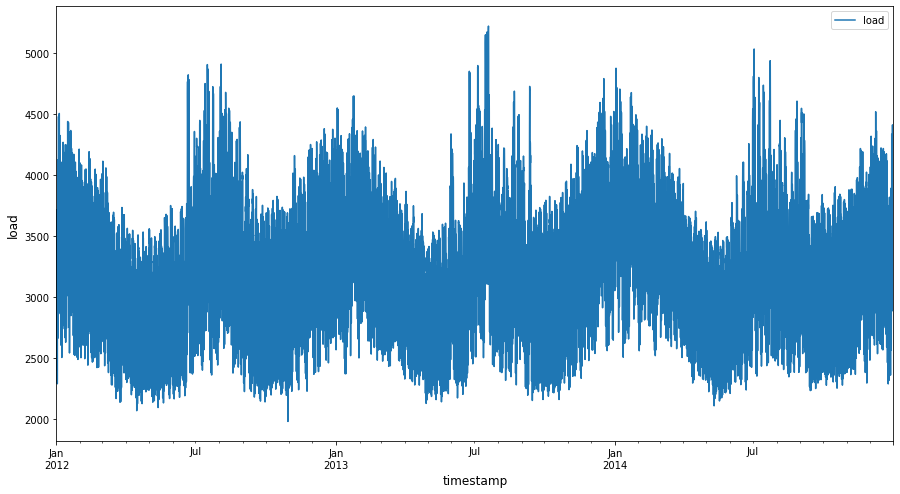

In [15]:
"""현재 날짜별 load분포 확인"""
energy.plot(figsize=(15, 8), fontsize=10)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

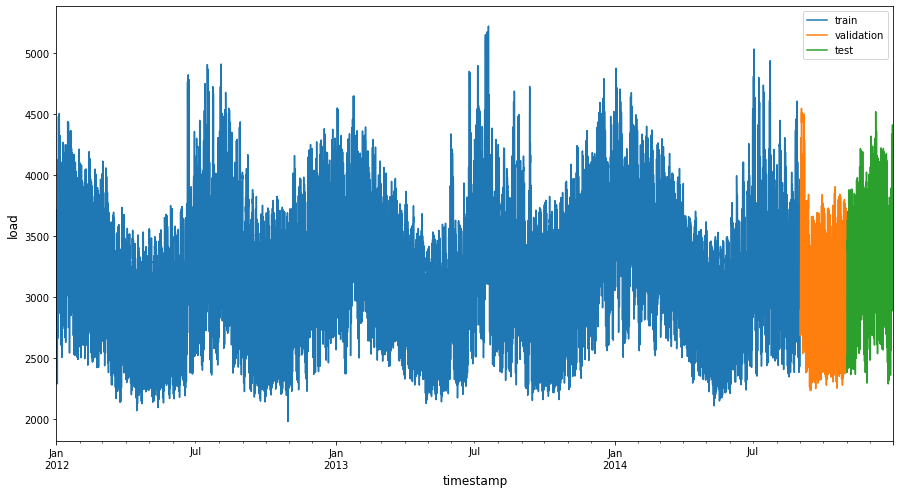

In [16]:
"""검증 데이터 시작 전 시간까지의 boolean인덱싱 후 load데이터만"""
train_date = energy.index < valid_start_dt
train_data = energy[train_date][['load']]

"""컬럼명 load를 train으로"""
train_data = train_data.rename(columns={'load':'train'})

#----------------------------------------
"""검증데이터셋 날짜 boolean 인덱싱"""
val_date = (energy.index >=valid_start_dt) & (energy.index < test_start_dt)

"""위의 날짜들만 load데이터로"""
val_data = energy[val_date][['load']] 

"""컬럼명 load를 validation으로"""
val_data = val_data.rename(columns={'load':'validation'})

"""train 데이터셋과 validation셋 outer Join"""
train_val_data = train_data.join(val_data, how='outer')

#----------------------------------------
"""테스트 데이터 날짜 load데이터"""
test_data = energy[test_start_dt:][['load']]

"""컬럼명 load를 test으로"""
test_data = test_data.rename(columns={'load':'test'})

"""train~val 데이터셋과 test셋 outer Join"""
data = train_val_data.join(test_data, how='outer')
                                     
"""그래프 그리기"""
data.plot(y=['train', 'validation', 'test'], figsize=(15, 8), fontsize=10)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

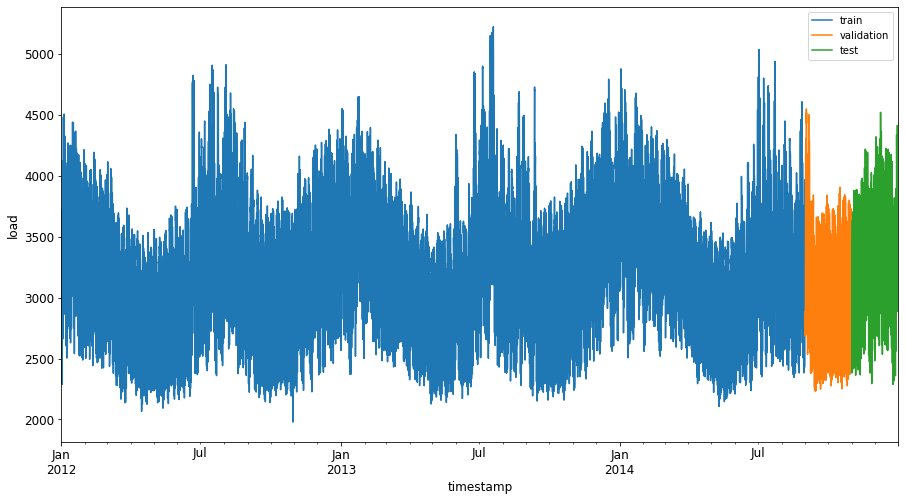

In [17]:
"""위에 그래프 원본 코드"""
energy[energy.index < valid_start_dt][['load']].rename(columns={'load':'train'}) \
    .join(energy[(energy.index >=valid_start_dt) & (energy.index < test_start_dt)][['load']] \
          .rename(columns={'load':'validation'}), how='outer') \
    .join(energy[test_start_dt:][['load']].rename(columns={'load':'test'}), how='outer') \
    .plot(y=['train', 'validation', 'test'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

## 훈련 데이터 세트 준비

- **time_step=6** : 예측을 위해 이전 6 단계 (t-5 ~ t)의 데이터를 사용한다는 의미 (실험을 통해 최적값 설정)
- **HORIZON=1** : 몇 단계 (시간)까지 예측할 것인지를 설정  (1시간, *t+1*)

In [18]:
from IPython.display import Image

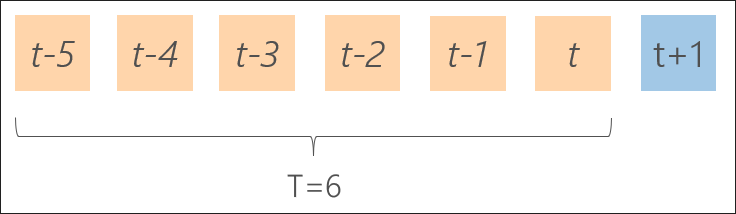

In [19]:
time_step = 6
HORIZON = 1 #출력층을 몇 단계 (시간)까지 예측할 것인지를 설정 (1시간, t+1) ()

훈련 데이터 세트를 준비하기 위해 아래 단계를 포함 :

(1) 필요한 기간만 포함되도록 원 데이터를 필터링하여 훈련 세트를 준비 <br>
(2) (0~1) 범위로 스케일링 <br>
(3) 한 개의 훈련 데이터에 모든 데이터를 포함하도록 시계열 값을 시프트하여  Pandas 데이터 프레임을 생성 <br>
(4) 누락된 값이 있는 샘플은 무시 <br>
(5) Keras에서 (samples, features) 형태의 numpy 배열로 Pandas 데이터 프레임을 변환 <br>

### 1. 필요한 기간만 포함되도록 원 데이터를 필터링하여 훈련 세트를 준비

In [20]:
"""train 데이터 준비 (날짜 자르기)"""
energy_copy = energy.copy()
train = energy_copy[energy_copy.index < valid_start_dt][['load']]
train.head()

,load
timestamp,
2012-01-01 00:00:00,"2,698.00"
2012-01-01 01:00:00,"2,558.00"
2012-01-01 02:00:00,"2,444.00"
2012-01-01 03:00:00,"2,402.00"
2012-01-01 04:00:00,"2,403.00"


### 2. (0~1) 범위로 스케일링

- (0~1)의 범위로 데이터를 스케일링 - 훈련 세트만 변환
- 검증 세트나 테스트 세트에서 훈련 세트로 누설되는 정보를 방지하기 위한 것

In [21]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train['load'] = scaler.fit_transform(train)
train.head(5)

,load
timestamp,
2012-01-01 00:00:00,0.22
2012-01-01 01:00:00,0.18
2012-01-01 02:00:00,0.14
2012-01-01 03:00:00,0.13
2012-01-01 04:00:00,0.13


### 원본데이터와 스케일링된 데이터 비교

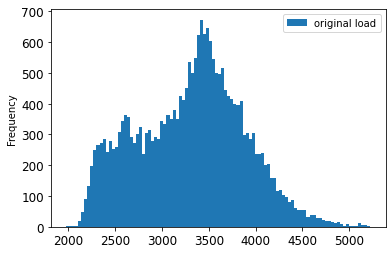

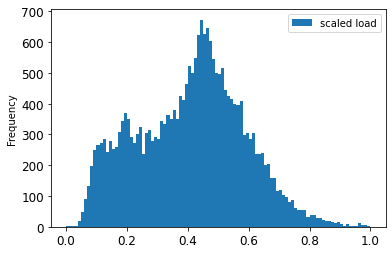

In [22]:
# bins = 100 : 100개의 bar 출력
scaler_before = energy[energy.index < valid_start_dt][['load']]\
                .rename(columns={'load':'original load'})
scaler_before.plot.hist(bins=100, fontsize=12)

scaler_after = train.rename(columns={'load':'scaled load'})
scaler_after.plot.hist(bins=100, fontsize=12)

plt.show()

### 3.한 개의 훈련 데이터에 모든 데이터를 포함하도록 시계열 값을 시프트하여  Pandas 데이터 프레임을 생성

- 먼저 **y_t + 1** 변수를 생성
- 데이터 프레임이 시간 **t**로 인덱싱되므로 **load** 변수를 한 시간(-1) 앞으로 이동하여  **y_t + 1** 변수에 저장
- freq 매개 변수를 사용하여 Pandas에게 시계열의 빈도를 시간으로 설정
- 시계열에서 누락된 기간을 뛰어 넘지 않도록 함.

In [23]:
train_shifted = train.copy()
train_shifted['y_t+1'] = train_shifted['load'].shift(-1, freq='H')#H는 시간단위, D는 일단위
train_shifted.head(10)

,load,y_t+1
timestamp,,
2012-01-01 00:00:00,0.22,0.18
2012-01-01 01:00:00,0.18,0.14
2012-01-01 02:00:00,0.14,0.13
2012-01-01 03:00:00,0.13,0.13
2012-01-01 04:00:00,0.13,0.15
2012-01-01 05:00:00,0.15,0.18
2012-01-01 06:00:00,0.18,0.23
2012-01-01 07:00:00,0.23,0.29
2012-01-01 08:00:00,0.29,0.35


### 입력 시퀸스을 생성하기 위해 이전 6개 시간의 load 변수를 시프트해야 함.

In [24]:
"""과거 t ~ t-5을 보기 위함"""
for t in range(1, time_step+1):
    train_shifted[str(time_step-t)] = train_shifted['load'].shift(time_step-t, freq='H')

In [25]:
train_shifted.head(10)

,load,y_t+1,5,4,3,2,1,0
timestamp,,,,,,,,
2012-01-01 00:00:00,0.22,0.18,nan,nan,nan,nan,nan,0.22
2012-01-01 01:00:00,0.18,0.14,nan,nan,nan,nan,0.22,0.18
2012-01-01 02:00:00,0.14,0.13,nan,nan,nan,0.22,0.18,0.14
2012-01-01 03:00:00,0.13,0.13,nan,nan,0.22,0.18,0.14,0.13
2012-01-01 04:00:00,0.13,0.15,nan,0.22,0.18,0.14,0.13,0.13
2012-01-01 05:00:00,0.15,0.18,0.22,0.18,0.14,0.13,0.13,0.15
2012-01-01 06:00:00,0.18,0.23,0.18,0.14,0.13,0.13,0.15,0.18
2012-01-01 07:00:00,0.23,0.29,0.14,0.13,0.13,0.15,0.18,0.23
2012-01-01 08:00:00,0.29,0.35,0.13,0.13,0.15,0.18,0.23,0.29


In [26]:
# column 설정
y_col = 'y_t+1'
X_cols = ['load_t-5', 'load_t-4', 'load_t-3', 'load_t-2', 'load_t-1', 'load_t']

train_shifted.columns = ['load_original']+[y_col]+X_cols
train_shifted.head(10)

,load_original,y_t+1,load_t-5,load_t-4,load_t-3,load_t-2,load_t-1,load_t
timestamp,,,,,,,,
2012-01-01 00:00:00,0.22,0.18,nan,nan,nan,nan,nan,0.22
2012-01-01 01:00:00,0.18,0.14,nan,nan,nan,nan,0.22,0.18
2012-01-01 02:00:00,0.14,0.13,nan,nan,nan,0.22,0.18,0.14
2012-01-01 03:00:00,0.13,0.13,nan,nan,0.22,0.18,0.14,0.13
2012-01-01 04:00:00,0.13,0.15,nan,0.22,0.18,0.14,0.13,0.13
2012-01-01 05:00:00,0.15,0.18,0.22,0.18,0.14,0.13,0.13,0.15
2012-01-01 06:00:00,0.18,0.23,0.18,0.14,0.13,0.13,0.15,0.18
2012-01-01 07:00:00,0.23,0.29,0.14,0.13,0.13,0.15,0.18,0.23
2012-01-01 08:00:00,0.29,0.35,0.13,0.13,0.15,0.18,0.23,0.29


### 4. 누락된 샘플이 있는 데이터는 제외 

- 0~4 시간 데이터간의 경우 일부 이전 데이터가 없으므로 제외시킴 (5시부터 사용)

In [27]:
# any : 컬럼의 데이터가 하나라도 na이면 데이터 삭제 
# all : 모든 데이터가 Na인 경우만 데이터 삭제
train_shifted = train_shifted.dropna(how='any')
train_shifted.head(10)

,load_original,y_t+1,load_t-5,load_t-4,load_t-3,load_t-2,load_t-1,load_t
timestamp,,,,,,,,
2012-01-01 05:00:00,0.15,0.18,0.22,0.18,0.14,0.13,0.13,0.15
2012-01-01 06:00:00,0.18,0.23,0.18,0.14,0.13,0.13,0.15,0.18
2012-01-01 07:00:00,0.23,0.29,0.14,0.13,0.13,0.15,0.18,0.23
2012-01-01 08:00:00,0.29,0.35,0.13,0.13,0.15,0.18,0.23,0.29
2012-01-01 09:00:00,0.35,0.37,0.13,0.15,0.18,0.23,0.29,0.35
2012-01-01 10:00:00,0.37,0.37,0.15,0.18,0.23,0.29,0.35,0.37
2012-01-01 11:00:00,0.37,0.37,0.18,0.23,0.29,0.35,0.37,0.37
2012-01-01 12:00:00,0.37,0.36,0.23,0.29,0.35,0.37,0.37,0.37
2012-01-01 13:00:00,0.36,0.35,0.29,0.35,0.37,0.37,0.37,0.36


### 5. Keras에서 사용하기 위해  Pandas 데이터 프레임을 (examples, features) 형태의 numpy 배열로 변환

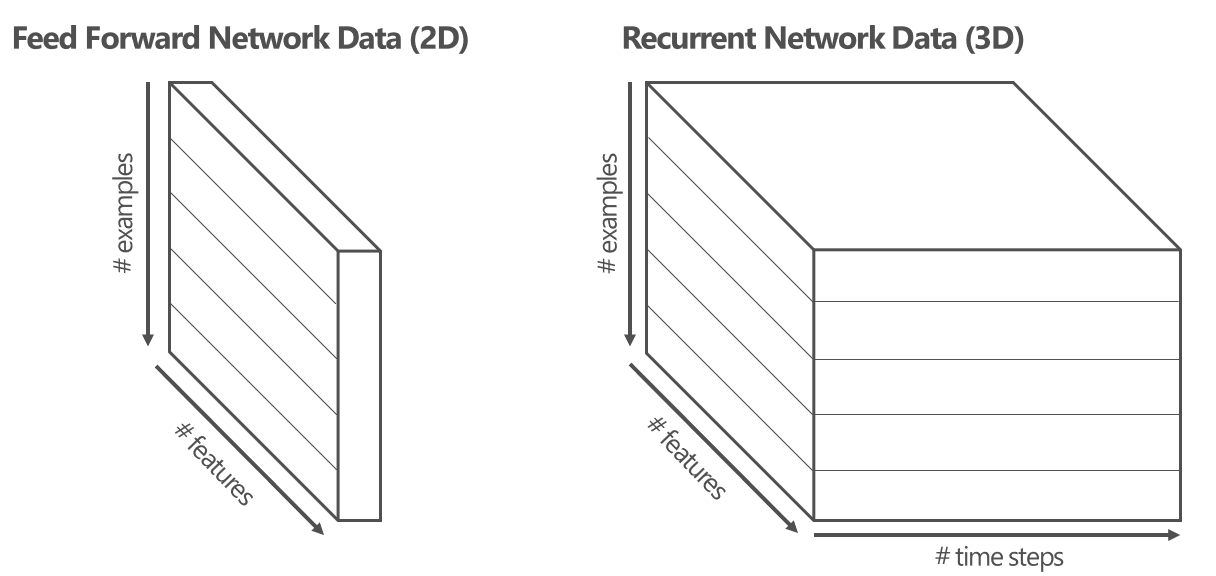

In [28]:
"""특성 데이터와 라벨 데이터를 분리하여 numpy 배열로 변환"""
y_train = train_shifted[y_col].values
X_train = train_shifted[X_cols].values
print(X_train.shape)
X_train[:2]

(23370, 6)


array([[0.22157165, 0.17842835, 0.14329738, 0.13035439, 0.13066256,
        0.14607088],
       [0.17842835, 0.14329738, 0.13035439, 0.13066256, 0.14607088,
        0.17904468]])

In [29]:
"""features가 1이기 때문에 reshape 마지막은 1"""
X_train = X_train.reshape(X_train.shape[0], time_step, 1)
X_train.shape

(23370, 6, 1)

In [30]:
print(y_train.shape)
y_train[:3]

(23370,)


array([0.17904468, 0.22804314, 0.28875193])

## 검증 데이터 준비


- 이전과 같이 비슷한 과정에 따라 검증 데이터 준비
- 초기 feature을 구성하기 위해 훈련 세트로 부터 time_step 시간을 유지 

In [31]:
"""검증 데이터만 가져오기"""
"""가져오기, 스케일링"""
valid_copy = energy.copy()
valid = valid_copy[(energy.index >= valid_start_dt) & (energy.index < test_start_dt)][['load']]
valid.head()

,load
timestamp,
2014-09-01 00:00:00,"2,886.00"
2014-09-01 01:00:00,"2,768.00"
2014-09-01 02:00:00,"2,699.00"
2014-09-01 03:00:00,"2,681.00"
2014-09-01 04:00:00,"2,690.00"


### 훈련 세트에 맞도록 검증데이터 시계열 스케일링


In [32]:
# 훈련 셋의 데이터 조사를 기반으로 검증 데이터를 스케일링
valid['load'] = scaler.transform(valid)
valid.head()

,load
timestamp,
2014-09-01 00:00:00,0.28
2014-09-01 01:00:00,0.24
2014-09-01 02:00:00,0.22
2014-09-01 03:00:00,0.22
2014-09-01 04:00:00,0.22


### 훈련 세트와 같이 동일한 방법으로 검증 데이터를 준비

In [33]:
valid_shifted = valid.copy()
valid_shifted['y+1'] = valid_shifted['load'].shift(-1, freq='H')

for t in range(1, time_step+1):
    valid_shifted['load_t-'+str(time_step-t)] = valid_shifted['load'].shift(time_step -t, freq='H')
    
valid_shifted = valid_shifted.dropna(how='any')
valid_shifted.head()

,load,y+1,load_t-5,load_t-4,load_t-3,load_t-2,load_t-1,load_t-0
timestamp,,,,,,,,
2014-09-01 05:00:00,0.24,0.28,0.28,0.24,0.22,0.22,0.22,0.24
2014-09-01 06:00:00,0.28,0.34,0.24,0.22,0.22,0.22,0.24,0.28
2014-09-01 07:00:00,0.34,0.44,0.22,0.22,0.22,0.24,0.28,0.34
2014-09-01 08:00:00,0.44,0.54,0.22,0.22,0.24,0.28,0.34,0.44
2014-09-01 09:00:00,0.54,0.60,0.22,0.24,0.28,0.34,0.44,0.54


In [34]:
y_valid = valid_shifted.loc[:,'y+1'].values
X_valid = valid_shifted.loc[:,'load_t-5':'load_t-0'].values
X_valid = X_valid.reshape(X_valid.shape[0], time_step, 1)

In [35]:
X_valid.shape

(1458, 6, 1)

In [36]:
y_valid.shape

(1458,)

## RNN 구현

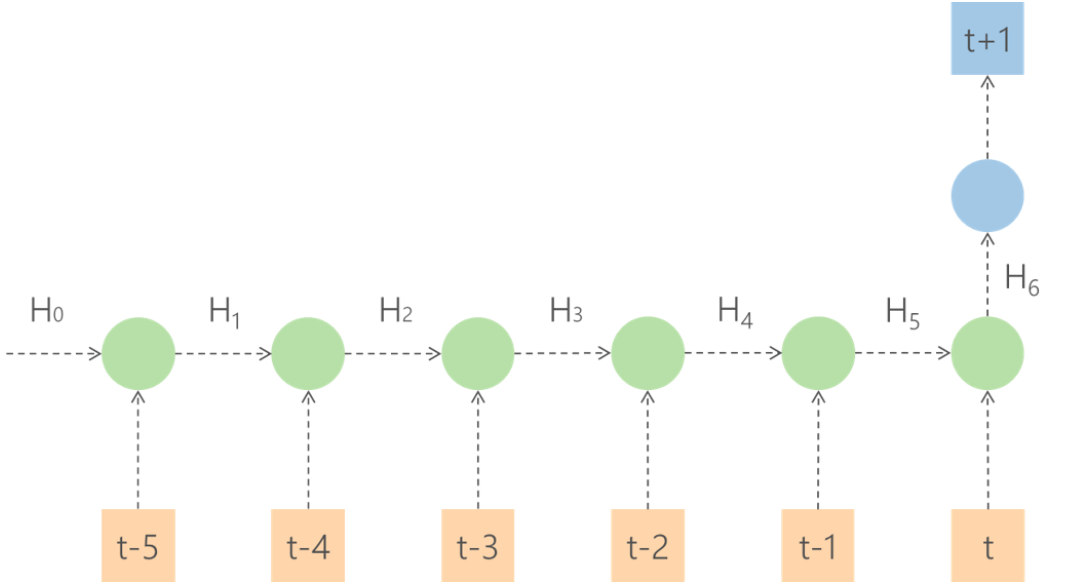

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [38]:
model = Sequential()
model.add(LSTM(units=5, input_shape=(time_step, 1)))
model.add(Dense(HORIZON))

model.compile(loss='mean_squared_error', 
              optimizer='RMSprop')

## Earlystopping

In [39]:
earlystop = EarlyStopping(monitor='val_loss', 
                          patience=5)

## ModelCheckpoint

In [40]:
best_val = ModelCheckpoint('model_save/energy_model_{epoch:02d}.h5', 
                           save_best_only=True, 
                           monitor='val_loss')

## Fit

In [41]:
history = model.fit(X_train,
                    y_train,
                    batch_size=32,
                    epochs=50,
                    validation_data=(X_valid, y_valid),
                    callbacks=[earlystop, best_val],
                    verbose=0)

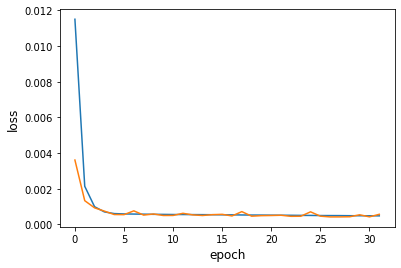

In [42]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

## 모델의 평가

- 테스트 세트 생성

In [43]:
energy_copy = energy.copy()
test = energy_copy[test_start_dt:][['load']]
test.head()

,load
timestamp,
2014-11-01 00:00:00,"2,514.00"
2014-11-01 01:00:00,"2,434.00"
2014-11-01 02:00:00,"2,390.00"
2014-11-01 03:00:00,"2,382.00"
2014-11-01 04:00:00,"2,419.00"


- 테스트 세트 스케일링

In [44]:
test['load'] = scaler.transform(test)
test.head()

,load
timestamp,
2014-11-01 00:00:00,0.16
2014-11-01 01:00:00,0.14
2014-11-01 02:00:00,0.13
2014-11-01 03:00:00,0.12
2014-11-01 04:00:00,0.14


- 테스트 세트 feature 생성

In [45]:
test_shifted = test.copy()
test_shifted['y_t+1'] = test_shifted['load'].shift(-1, freq='H')

for t in range(1, time_step+1):
    test_shifted['load_t-'+str(time_step-t)] = test_shifted['load'].shift(time_step-t, freq='H')
    
test_shifted = test_shifted.dropna(how='any')

y_test = test_shifted.loc[:,'y_t+1'].values
X_test = test_shifted.loc[:,'load_t-5':"load_t-0"].values
X_test = X_test.reshape(X_test.shape[0],time_step, 1)
X_test[:2]

array([[[0.16486903],
        [0.14021572],
        [0.12665639],
        [0.12419106],
        [0.13559322],
        [0.16671803]],

       [[0.14021572],
        [0.12665639],
        [0.12419106],
        [0.13559322],
        [0.16671803],
        [0.22650231]]])

- 테스트 세트를 이용한 평가 및 예측

In [46]:
model.evaluate(X_test)

46/46 [==============================] - 0s 861us/step - loss: 0.0000e+00


0.0

In [47]:
pre = model.predict(X_test)
pre

array([[0.23413321],
       [0.31304023],
       [0.38847068],
       ...,
       [0.5487421 ],
       [0.47806144],
       [0.4441946 ]], dtype=float32)

# 실제 load와 예측 값을 비교

In [48]:
eval_df = pd.DataFrame(pre, columns=['t+1'])

eval_df['timestamp'] = test_shifted.index

eval_df.head()

,t+1,timestamp
0,0.23,2014-11-01 05:00:00
1,0.31,2014-11-01 06:00:00
2,0.39,2014-11-01 07:00:00
3,0.43,2014-11-01 08:00:00
4,0.47,2014-11-01 09:00:00


In [49]:
# eval_df 데이터를 timestamp를 기준으로 t+1 값을 배치하고 
#변수 커럼명을 h, 
#값 컬럼명을 prediction로 재구성
eval_df = pd.melt(eval_df, 
                  id_vars='timestamp', 
                  var_name='h', 
                  value_name='prediction')

eval_df.head()

,timestamp,h,prediction
0,2014-11-01 05:00:00,t+1,0.23
1,2014-11-01 06:00:00,t+1,0.31
2,2014-11-01 07:00:00,t+1,0.39
3,2014-11-01 08:00:00,t+1,0.43
4,2014-11-01 09:00:00,t+1,0.47


In [50]:
#transpose : 행과 열 바꾸기(전치행렬)
np.transpose(y_test)

array([0.22650231, 0.30539291, 0.37288136, ..., 0.52141757, 0.46841294,
       0.42095532])

In [51]:
"""actual(실제) 컬럼을 생성하여 실제 값을 저장"""
eval_df['actual'] = np.transpose(y_test)

eval_df.head(5)

,timestamp,h,prediction,actual
0,2014-11-01 05:00:00,t+1,0.23,0.23
1,2014-11-01 06:00:00,t+1,0.31,0.31
2,2014-11-01 07:00:00,t+1,0.39,0.37
3,2014-11-01 08:00:00,t+1,0.43,0.42
4,2014-11-01 09:00:00,t+1,0.47,0.45


In [52]:
"""원래 수치로 바껴야 비교가능"""
# 예측값과 실제값의 원래 값을 복원하여 표시
eval_df[['prediction', 'actual']] = \
            scaler.inverse_transform(eval_df[['prediction', 'actual']])
eval_df.head(5)

,timestamp,h,prediction,actual
0,2014-11-01 05:00:00,t+1,"2,738.76","2,714.00"
1,2014-11-01 06:00:00,t+1,"2,994.82","2,970.00"
2,2014-11-01 07:00:00,t+1,"3,239.59","3,189.00"
3,2014-11-01 08:00:00,t+1,"3,374.24","3,356.00"
4,2014-11-01 09:00:00,t+1,"3,508.12","3,436.00"


- 테스트 세트의 첫번째 주에서 실제값과 예측값 비교

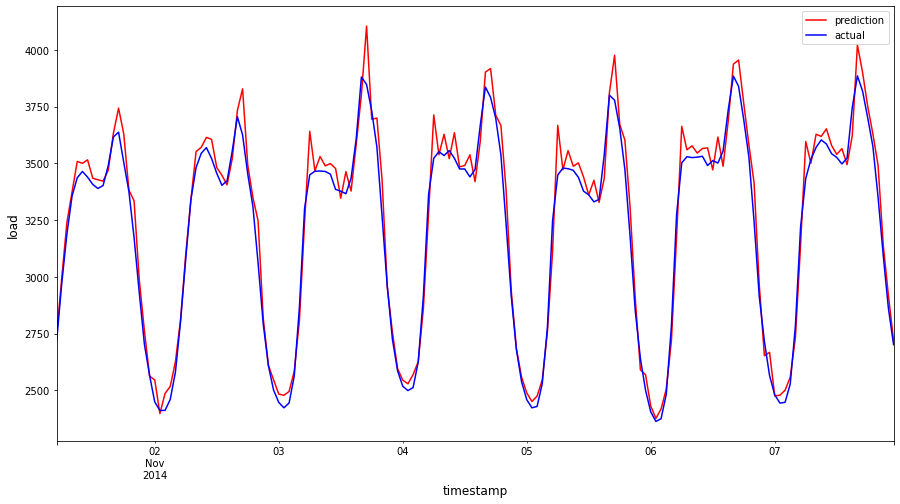

In [53]:
"""14년 11월부터 데이터가 있으나 너무 많으면 잘 안보여서 조금만 잘라서 그림"""
eval_df[eval_df["timestamp"] <' 2014-11-08'].plot(x='timestamp', 
                                             y=['prediction', 'actual'], 
                                             style=['r', 'b'], #색깔
                                             figsize=(15, 8)) #사이즈

plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()